# RNN을 이용한 문서 분류
## RNN(Recurrent Neural Networks)
- 순차 데이터나 시계열 데이터를 다루는 모형
- 입/출력을 시퀀스로 처리함 -> 단어의 순서를 고려하므로 문맥 파악에 좋음
- 활성화 함수: tanh(하이퍼볼릭 탄젠트)

<br/> <br/>
> 시계역 데이터: 일정 시간 간격으로 측정된 데이터 &nbsp; &nbsp; ex) 한 시간마다 측정한 기온 <br/>
&nbsp; &nbsp; 시계열 모형에서는 앞의 값들이 뒤의 값에 영향을 미친다고 가정함 <br/>
&nbsp; &nbsp; ex) t시점 온도 x(t) 예측을 위해 그 전 4시간의 온도 [x(t-4), x(t-3), x(t-2), x(t-1)] 를 입력으로 사용

<br/> <br/>
## [RNN vs Feed Forward](https://wikidocs.net/22886)
### RNN의 구조
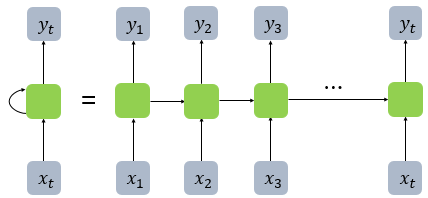
- x: 입력 벡터
- 초록색: 셀, 이전 값을 기억하는 일종의 메모리 역할, **다음 시점 t+1에 값을 보냄 -> 은닉 상태(hidden state)**
- y: 출력 벡터
> 수식 <br/>
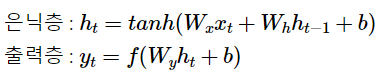

### 순방향 신경망(Feed Forward Nueral Network)
- 노드 간의 연결이 순환을 생성하지 않음
- 입력층 -> 은닉층 -> 출력층
- ex) CNN

<br/> <br/>

## RNN 유형
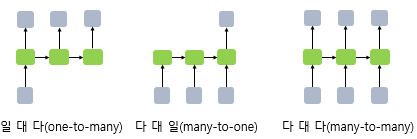
- 일대일(Fixsed size) ex) 이미지 분류
- 일대다(Sequence output) ex) 이미지 캡셔닝
- 다대일(Sequence input) ex) 감성분석 신경망
- 다대다(Sequence to sequence) ex) 기계번역

<br/> <br/>

## RNN 단점
**기울기 소실 문제(Gradient Vanishing)**: 입력층에 가까운 층들에서 기울기가 작아져 가중치가 제대로 업데이트 되지 않는 문제 <br/>
&nbsp; &nbsp; tanh를 활성화 함수로 사용해서 발생하는 문제 => 장기 의존성 문제 <br/>

이를 해결하기 위해 LSTM(Long Short-Term Memory)이 등장
<br/> <br/> <br/>

In [6]:
# RNN을 이용해 NLTK 영화 리뷰 감성분석에 앞서
# 데이터 전처리

from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids()

reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

print("reviews count: ", len(reviews))
print("first review: ", len(reviews[0]))
print("Labels: ", set(categories))

reviews count:  2000
first review:  4043
Labels:  {'neg', 'pos'}


In [7]:
# keras의 토크나이저를 이용해 문서를 인덱스의 시퀀스로 변환
# ex) "I am so happy" -> ['I', 'am', 'so', 'happy'] -> [7, 2, 9, 13]

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 #사용할 단어의 수

tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')  # 토크나이저, oov_token: 사전에 없는 단어 처리 가능, 여기서는 공통값으로 대체

tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

X = tokenizer.texts_to_sequences(reviews)   # 문서를 단어 인덱스로 변환

print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])       # 인덱스 시퀀스의 길이가 제각기 다름 -> 크기를 맞춰야 함

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [9]:
# 단어의 인덱스 확인
print("Index of 'the': ", tokenizer.word_index["the"])
print("Index of 'review': ", tokenizer.word_index["review"])
print("Index of 'good': ", tokenizer.word_index["good"])
print("Index of 'marvel': ", tokenizer.word_index["marvel"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])
print("Index length: ", len(tokenizer.word_index))

Index of 'the':  2
Index of 'review':  466
Index of 'good':  62
Index of 'marvel':  5998
Index of out-of-vocabulary words: 1
Index length:  43297


In [10]:
# 입력 변환
# 가변적인 인덱스 시퀀스 길이를 동일한 크기로 변환

from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 500 #문서의 단어 수를 제한

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지 선택할 수 있음. 앞을 자르고 뒷부분을 쓰고자 하면 'pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre') 

In [11]:
# 출력 변환
import numpy as np

# label을 0, 1의 값으로 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


In [12]:
# train/test split
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


In [13]:
## 1. 일반 신경망 모델을 이용해 분류
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential([ #순차적 모형
    Embedding(max_words, 32, input_length=maxlen), #Embedding: 워드 임베딩 수행
    # max_words는 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32 크기의 dense vector로 embedding 됨
    # input_length: 한 document의 단어 수
    # 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(), # 2차원 -> 1차원
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])

model.summary() #모델의 요약정보 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# 학습
history = model.fit(X_train, y_train, 
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 5s 27ms/step - loss: 0.6913 - acc: 0.5281 - val_loss: 0.6858 - val_acc: 0.5688
Epoch 2/10
40/40 [==============================] - 1s 13ms/step - loss: 0.5859 - acc: 0.9234 - val_loss: 0.6737 - val_acc: 0.6156
Epoch 3/10
40/40 [==============================] - 1s 20ms/step - loss: 0.4473 - acc: 0.9773 - val_loss: 0.6494 - val_acc: 0.6406
Epoch 4/10
40/40 [==============================] - 1s 15ms/step - loss: 0.2894 - acc: 0.9945 - val_loss: 0.6198 - val_acc: 0.6469
Epoch 5/10
40/40 [==============================] - 1s 14ms/step - loss: 0.1608 - acc: 0.9984 - val_loss: 0.5920 - val_acc: 0.6844
Epoch 6/10
40/40 [==============================] - 1s 15ms/step - loss: 0.0786 - acc: 0.9992 - val_loss: 0.5762 - val_acc: 0.6719
Epoch 7/10
40/40 [==============================] - 1s 13ms/step - loss: 0.0348 - acc: 1.0000 - val_loss: 0.5645 - val_acc: 0.6938
Epoch 8/10
40/40 [==============================] - 1s 19ms/step - loss: 0.0140 - a

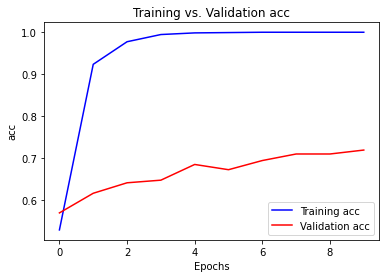

In [15]:
# accuracy 시각화
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'acc')
# 과대 적합의 가능성이 있음

In [18]:
# 모델 평가
score = model.evaluate(X_test, y_test)
print(f'#Test loss:{score[0]:.3f}')
print(f'#Test accuracy:{score[1]:.3f}')

13/13 [==============================] - 0s 10ms/step - loss: 0.5605 - acc: 0.7225
#Test loss:0.561
#Test accuracy:0.723
